# Compressing DLRM

**Deep-learning recommendation models** (DLRMs) account for a vast portion of industry-scale ML workloads, from ranking relevant posts in news and social network feeds (comprising ~80% of AI inference cycles at Meta [[Gupta *et al.*, 2020](https://www.computer.org/csdl/proceedings-article/hpca/2020/614900a488/1j9wuchShGM)]) to making user-tailored suggestions on streaming platforms and e-commerce websites (driving up to 35% of Amazon's revenue in 2018 [[McKinsey](https://www.mckinsey.com/industries/retail/our-insights/how-retailers-can-keep-up-with-consumers)]). One key challenge of such models is the need of encoding sparse features (e.g. research keywords, product brands or user demographics), which — for the largest datasets — can assume hundreds of millions, if not billions, of different categorical values [[Ardalani *et al.*, 2022](https://arxiv.org/abs/2208.08489)]. The standard way of representing them is to learn a dense **embedding** for each categorical value [[Naumov *et al.*, 2019](https://arxiv.org/abs/1906.00091)], giving rise to huge, sparsely-accessed embedding tables — whose size can easily surpass the tens of terabytes. The sheer size of these tables poses significant engineering challenges and costs when coming up with solutions to efficiently train and deploy large DLRMs on AI accelerators [[Gupta *et al.*, 2020](https://www.computer.org/csdl/proceedings-article/hpca/2020/614900a488/1j9wuchShGM)], [[Mudigere *et al.*, 2022](https://dl.acm.org/doi/abs/10.1145/3470496.3533727)], typically requiring model distribution across multiple nodes just to be able to fit all parameters and complex memory management to distribute embeddings across a hierarchical sequence of storage supports (on-chip memory, host DRAM and SSDs) based on access frequency (see for instance Meta's hardware-software co-designed platform, ZionEx [[Mudigere *et al.*, 2022](https://dl.acm.org/doi/abs/10.1145/3470496.3533727)], dedicated to DLRM workloads).

While the size of production-level DLRMs has steadily kept growing over the years [[Mudigere *et al.*, 2022](https://dl.acm.org/doi/abs/10.1145/3470496.3533727)], recent evidence [[Ardalani *et al.*, 2022](https://arxiv.org/abs/2208.08489)] suggests that — differently from Large Language Models — the canonical DLRM architectures are already significantly over-parametrized, operating way past the point of diminishing returns of their scaling law. As a consequence, a new interest in **compression techniques** for DLRMs has arisen [[Kang *et al.*, 2021](https://dl.acm.org/doi/10.1145/3447548.3467304)], [[Desai *et al.*, 2022](https://proceedings.neurips.cc/paper_files/paper/2022/hash/dbae915128892556134f1c5375855590-Abstract-Conference.html)], [[Hsia *et al.*, 2023](https://dl.acm.org/doi/10.1145/3582016.3582068)], investigating the possibility of **trading-off memory for compute** by generating embeddings on-the-fly when needed from a smaller set of trainable parameters, instead of having to store all of them all the time. In this research notebook we will present some of these compression techniques and apply them to a basic DLRM architecture, analyzing their impact. As a study case we will run experiments on the [*Criteo 1TB Click Logs*](https://ailab.criteo.com/criteo-1tb-click-logs-dataset/) dataset for click-through-rate (CTR) prediction, commonly used for the recommendation benchmark of [MLPerf](https://mlcommons.org/en/training-normal-21/).

Disclaimer: **the focus of this research notebook is educational**, hence the provided implementation (similarly to the code in Meta's DLRM [repository](https://github.com/facebookresearch/dlrm/tree/main), upon which we base ourselves) is meant to be used as proof of concept and is not in any way optimized for throughput. 

## Environment setup

The best way to run this demo is on Paperspace Gradient's cloud IPUs because everything is already set up for you.

 [![Run on Gradient](https://assets.paperspace.io/img/gradient-badge.svg)]()

To run the demo using other IPU hardware, you need to have the Poplar SDK enabled and a PopTorch wheel installed. Refer to the [Getting Started guide](https://docs.graphcore.ai/en/latest/getting-started.html#getting-started) for your system for details on how to do this. Also refer to the [Jupyter Quick Start guide](https://docs.graphcore.ai/projects/jupyter-notebook-quick-start/en/latest/index.html) for how to set up Jupyter to be able to run this notebook on a remote IPU machine.

## Dependencies

In [ ]:
!pip install numpy wandb scikit-learn intel_extension_for_pytorch

In [1]:
import math
import os
import sys
import time
from dataclasses import dataclass
from pathlib import Path
from typing import *

import numpy as np
import poptorch
import torch
import torch.nn as nn
from utils import CriteoBinDataset, WandBLogger

try:
    # CPU multi-thread roc_auc_score implementation
    from intel_extension_for_pytorch._C import roc_auc_score
except:
    from sklearn.metrics import roc_auc_score

In [3]:
# environment variables
os.environ["DATASET_DIR"] = "/net/group/research/criteo_datasets/criteo_terabyte/"

dataset_dir = Path(os.getenv("DATASET_DIR"))
# checkpoint_dir = Path(os.getenv("CHECKPOINT_DIR"))
NUM_AVAILABLE_IPUS = 16

The following cell downloads the preprocessed *Criteo 1TB* dataset. Notice that the training dataset is sizeable (~625 GB): we recommend downloading it (by uncommenting the corresponding line in the cell) only if the user is interested in running training firsthand. We advise against doing so on machines with less than 16 IPUs.

We also download checkpoints of trained models that can be used to run inference and compare the final performance on the test dataset.

In [4]:
%%bash
# download the test dataset
# aws s3 --no-sign-request cp s3://graphcore-research-public/2023-dlrm-notebook/day_fea_count.npz $DATASET_DIR/day_fea_count.npz
# aws s3 --no-sign-request cp s3://graphcore-research-public/2023-dlrm-notebook/terabyte_processed_val.bin $DATASET_DIR/terabyte_processed_val.bin

# uncomment the following line to download the train dataset
# !aws s3 --no-sign-request cp s3://graphcore-research-public/2023-dlrm-notebook/terabyte_processed_train.bin $DATASET_DIR/terabyte_processed_train.bin

# download model checkpoints

## The DLRM model

We base our recommender model on the public-source DLRM [[Naumov *et al.*, 2019](https://arxiv.org/abs/1906.00091)] implementation by Meta ([github repository](https://github.com/facebookresearch/dlrm/tree/main)). The model's inputs are divided between dense features and sparse features: we represent the former as a floating point vector $\textbf{y} \in \mathbb{R}^d$, while for each sparse feature the input consists of the integer ID of the corresponding categorical value. For the sake of simplicity (and because this is the case in the *Criteo 1TB* dataset) in the following we will assume that each datapoint encodes a single categorical value for each sparse feature, hence the categorical inputs can be represented by a vector $\textbf{x} \in \mathbb{N}^s$, where $s$ is the number of sparse features. More generally, multiple categorical values may need to be combined for each sparse feature, and everything we will present can be easily extended to this case.   

The standard DLRM implementation uses **embedding operators** to map each categorical value to a dense representation. If $n_k$ is the number of categories for the $k$-th sparse feature, the embedding of its $i$-th categorical value is given by the $i$-th row of a trainable embedding table $E_k \in \mathbb{R}^{n_k,e}$, with $e$ being the embedding size. Starting from the categorical input $\textbf{x} \in \mathbb{N}^s$ we therefore look-up the $s$ embeddings $\textbf{e}_1, \dots, \textbf{e}_s \in \mathbb{R}^e$, where $\textbf{e}_k$ is the $x_k$-th row of $E_k$. An additional $e$-dimensional vector is generated from the dense input $\textbf{y}$ by passing it through an MLP stack (called **bottom MLP**), namely $\textbf{e}_0 := \text{MLP}_{\text{bot}}(\textbf{y}) \in \mathbb{R}^e$. The $s+1$ vectors $\textbf{e}_0, \dots, \textbf{e}_s$ are then combined through an **interaction operator**: this could be chosen to be simple concatenation $\text{int}(\textbf{e}_0, \dots, \textbf{e}_s) := \text{concat}(\textbf{e}_0, \dots, \textbf{e}_s) \in \mathbb{R}^{(s+1)e}$, or a more complex operation like computing all distinct pairwise dot products $\text{int}(\textbf{e}_0, \dots, \textbf{e}_s) := (\textbf{e}_i \cdot \textbf{e}_j)_{i < j} \in \mathbb{R}^{s+1 \choose 2}$ (in practice, this vector is then usually concatenated with $\textbf{e}_0$). The result of the interaction operator goes through a final MLP stack (called **top MLP**) with 1-dimensional output $l = \text{MLP}_{\text{top}}(\text{int}(\textbf{e}_0, \dots, \textbf{e}_s)) \in \mathbb{R}$, which is interpreted as the logit of the click-through-rate probability.

<img src="img/DLRM.jpg" height="400">

In [5]:
# Adapted from https://github.com/facebookresearch/dlrm/blob/main/dlrm_s_pytorch.py


class DLRM(nn.Module):
    def create_mlp(self, layers_size, sigmoid_layer):
        layers = nn.ModuleList()
        for i in range(len(layers_size) - 1):
            in_dim, out_dim = layers_size[i], layers_size[i + 1]

            LL = nn.Linear(int(in_dim), int(out_dim), bias=True)
            mean = 0.0
            std_dev_w = np.sqrt(2 / (in_dim + out_dim))
            W = np.random.normal(mean, std_dev_w, size=(out_dim, in_dim)).astype(
                np.float32
            )
            std_dev_b = np.sqrt(1 / out_dim)
            b = np.random.normal(mean, std_dev_b, size=out_dim).astype(np.float32)
            LL.weight.data = torch.tensor(W, requires_grad=True)
            LL.bias.data = torch.tensor(b, requires_grad=True)
            layers.append(LL)

            if i == sigmoid_layer:
                layers.append(nn.Sigmoid())
            else:
                layers.append(nn.ReLU())

        return torch.nn.Sequential(*layers)

    def create_emb(self, emb_dim, tables_size):
        emb_l = nn.ModuleList()
        for t_size in tables_size:
            EE = nn.Embedding(t_size, emb_dim)
            W = np.random.uniform(
                low=-np.sqrt(1 / t_size),
                high=np.sqrt(1 / t_size),
                size=(t_size, emb_dim),
            ).astype(np.float32)
            EE.weight.data = torch.tensor(W, requires_grad=True)
            emb_l.append(EE)
        return emb_l

    @property
    def n_emb_parameters(self) -> int:
        return sum([x.numel() for x in self.emb_list.parameters()])

    def __init__(
        self,
        emb_dim: int,
        emb_table_sizes: list,
        mlp_layers_size_bot: str,
        mlp_layers_size_top: str,
        arch_interaction_op: str,
        arch_interaction_itself: bool = False,
        sigmoid_bot: int = -1,
        sigmoid_top: int = -1,
        loss_threshold: float = 0.0,
        loss_function: str = "bce",
        loss_weights: str = None,
    ):
        super(DLRM, self).__init__()
        self.arch_interaction_op = arch_interaction_op
        self.arch_interaction_itself = arch_interaction_itself
        self.loss_threshold = loss_threshold
        self.loss_function = loss_function

        # Bottom and top MLP stacks
        self.bot_mlp = self.create_mlp(mlp_layers_size_bot, sigmoid_bot)
        self.top_mlp = self.create_mlp(mlp_layers_size_top, sigmoid_top)

        # List of embedding operators
        self.emb_list = self.create_emb(emb_dim, emb_table_sizes)

        # Loss function
        if self.loss_function == "mse":
            self.loss_fn = torch.nn.MSELoss(reduction="mean")
        elif self.loss_function == "bce":
            self.loss_fn = torch.nn.BCELoss(reduction="mean")
        elif self.loss_function == "wbce":
            self.register_buffer(
                "loss_ws",
                torch.tensor(np.fromstring(loss_weights, dtype=float, sep="-")),
            )
            self.loss_fn = torch.nn.BCELoss(reduction="none")
        else:
            sys.exit(
                "ERROR: --loss-function=" + self.loss_function + " is not supported"
            )

    def apply_mlp(self, x, layers):
        return layers(x)

    def apply_emb(self, lookup_ids):
        ly = []
        for k, t in enumerate(self.emb_list):
            ly.append(t(lookup_ids[:, k]))
        out = torch.stack(ly, dim=1)  # shape (bs, n_sparse_features, emb_dim)
        return out

    def interact_features(self, dense_feat, sparse_feat):
        if self.arch_interaction_op == "dot":
            # concatenate dense and sparse features
            T = torch.cat(
                [dense_feat.unsqueeze(1), sparse_feat], dim=1
            )  # shape (bs, 1 + n_sparse_features, emb_dim)
            # perform a dot product
            Z = torch.bmm(T, torch.transpose(T, 1, 2))
            _, ni, nj = Z.shape
            offset = 1 if self.arch_interaction_itself else 0
            li = torch.tensor(
                [i for i in range(ni) for j in range(i + offset)],
                device=dense_feat.device,
                dtype=torch.int32,
            )
            lj = torch.tensor(
                [j for i in range(nj) for j in range(i + offset)],
                device=dense_feat.device,
                dtype=torch.int32,
            )
            Zflat = Z[:, li, lj]
            # final output is concatenation of dense features and pairwise interactions
            R = torch.cat([dense_feat] + [Zflat], dim=1)
        elif self.arch_interaction_op == "cat":
            # concatenation features (into a row vector)
            R = torch.cat(
                [dense_feat, sparse_feat.view(sparse_feat.shape[0], -1)], dim=1
            )
        else:
            sys.exit(
                "ERROR: --arch-interaction-op="
                + self.arch_interaction_op
                + " is not supported"
            )

        return R

    def forward(self, dense_x, lS_i, labels=None):
        """
        dense_x: shape (bs, n_dense_features)
            Values of dense features.
        lS_i: shape (bs, n_sparse_features)
            Categorical value IDs of sparse features.
        labels (optional): shape (bs, 1)
            CTR labels (0/1).

        Returns:
            CTR probability: shape (bs, 1)
            Reduced batch loss (if labels are provided): shape (,)
        """
        # requirement for poptorch dataloader
        dense_x = dense_x.squeeze(0)
        lS_i = lS_i.squeeze(0)
        if labels is not None:
            labels = labels.squeeze(0)

        # process dense features (using bottom mlp)
        dense_feat = self.apply_mlp(dense_x, self.bot_mlp)

        # process sparse features (using embedding operators)
        sparse_feat = self.apply_emb(lS_i)

        # interact features (dense and sparse)
        z = self.interact_features(dense_feat, sparse_feat)

        # obtain probability of a click (using top mlp)
        out = self.apply_mlp(z, self.top_mlp)

        # clamp output if needed
        if 0.0 < self.loss_threshold and self.loss_threshold < 1.0:
            out = torch.clamp(
                out, min=self.loss_threshold, max=(1.0 - self.loss_threshold)
            )

        if labels is not None:
            loss = self.loss_fn(out, labels)
            if self.loss_function == "wbce":
                loss_ws_ = self.loss_ws[labels.data.view(-1)].view_as(labels)
                loss = poptorch.identity_loss(loss_ws_ * loss, reduction="sum")
            out = [out, loss]

        return out

## Embedding compression

The total number of trainable parameters in DLRM is given by:  `#params_MLP_bot + #params_MLP_top + #params_embedding`, with `#params_embedding = e*(n_1+...+n_s)` typically accounting for the vast majority of the total [[Ardalani *et al.*, 2022](https://arxiv.org/abs/2208.08489)]. Let us look for instance at the *Criteo 1TB* dataset, taking the sizes for embeddings and MLP layers as in the [reference MLPerf configuration](https://github.com/facebookresearch/dlrm/blob/main/bench/run_and_time.sh).

In [6]:
# Categorical value counts per sparse feature
with np.load(dataset_dir.joinpath("day_fea_count.npz")) as data:
    counts = data["counts"]

n_byte_per_parameter = {"fp32": 4, "fp16": 2}

n_sparse = counts.shape[0]
emb_size = 128
dtype = "fp32"

print(f"Number of sparse features: {n_sparse}")
print(f"Number of categorical values per feature: {counts.tolist()}")
print(f"Total number of categories: {counts.sum():,}")
print(f"Embedding size: {emb_size:,}")
print(f"Total number of embedding parameters: {emb_size * counts.sum():,}")
print(
    f"Total size of embedding parameters ({dtype}): {n_byte_per_parameter[dtype] * emb_size * counts.sum() / 1e9:.5} GB"
)

Number of sparse features: 26
Number of categorical values per feature: [227605432, 39060, 17295, 7424, 20265, 3, 7122, 1543, 63, 130229467, 3067956, 405282, 10, 2209, 11938, 155, 4, 976, 14, 292775614, 40790948, 187188510, 590152, 12973, 108, 36]
Total number of categories: 882,774,559
Embedding size: 128
Total number of embedding parameters: 112,995,143,552
Total size of embedding parameters (fp32): 451.98 GB


In [7]:
n_dense = 13
mlp_bot_layers = [n_dense, 512, 256, emb_size]
# Assume dot product interaction without self-interactions
n_interactions = n_sparse * (n_sparse + 1) // 2
mlp_top_layers = [emb_size + n_interactions] + [1024, 1024, 512, 256, 1]

# Sum of parameters (weights and biases) over all linear layers
mlp_bot_params = sum(
    [
        (mlp_bot_layers[i] + 1) * mlp_bot_layers[i + 1]
        for i in range(len(mlp_bot_layers) - 1)
    ]
)
mlp_top_params = sum(
    [
        (mlp_top_layers[i] + 1) * mlp_top_layers[i + 1]
        for i in range(len(mlp_top_layers) - 1)
    ]
)

print(f"Number of dense features: {n_dense}")
print(f"Number of bottom MLP parameters: {mlp_bot_params:,}")
print(f"Number of top MLP parameters: {mlp_top_params:,}")
print(
    f"Total size of MLP parameters ({dtype}): {n_byte_per_parameter[dtype] * (mlp_bot_params + mlp_top_params) / 1e9:.5} GB"
)

Number of dense features: 13
Number of bottom MLP parameters: 171,392
Number of top MLP parameters: 2,197,505
Total size of MLP parameters (fp32): 0.0094756 GB


As we see, **embedding parameters account for > 99.99% of all parameters in the model**, requiring almost half a TB of memory to be stored! Embedding compression techniques aim to reduce the size of embedding parameters. A basic form of compression, known as **Hashing Trick** [[Weinberger *et al.*, 2009](https://dl.acm.org/doi/10.1145/1553374.1553516)], is already present in the DLRM source code: it consists of vertically cropping the largest embedding tables, by imposing a maximum number of rows per table. Categorical values' IDs are then hashed to this smaller range: as a consequence, some embeddings will be shared among multiple categorical values. If $M$ is the maximum number of rows allowed, then the embedding for the $i$-th categorical value is retrieved by looking-up the $(i \mod M)$-th row of the table. This is explicitly used in the [MLPerf reference configuration](https://github.com/facebookresearch/dlrm/blob/main/bench/run_and_time.sh) for *Criteo 1TB*, with `M = 4e7`, resulting in a reduction of the number of embedding parameters of approximately 4x:

In [8]:
max_ind_range = 40000000  # M
ht_counts = np.minimum(counts, max_ind_range)

print("Hashing Trick:")
print(f"Number of rows in cropped embedding tables: {ht_counts.tolist()}")
print(f"Total number of unique embeddings: {ht_counts.sum():,}")
print(f"Embedding size: {emb_size:,}")
print(f"Total number of embedding parameters: {emb_size * ht_counts.sum():,}")
print(
    f"Total size of embedding parameters ({dtype}): {n_byte_per_parameter[dtype] * emb_size * ht_counts.sum() / 1e9:.5} GB"
)

Hashing Trick:
Number of rows in cropped embedding tables: [40000000, 39060, 17295, 7424, 20265, 3, 7122, 1543, 63, 40000000, 3067956, 405282, 10, 2209, 11938, 155, 4, 976, 14, 40000000, 40000000, 40000000, 590152, 12973, 108, 36]
Total number of unique embeddings: 204,184,588
Embedding size: 128
Total number of embedding parameters: 26,135,627,264
Total size of embedding parameters (fp32): 104.54 GB


Hashing Trick forces multiple categorical values to have the same exact embedding, potentially limiting the model's expressivity. We now present two more advanced compression techniques which will allow us to overcome this limitation.

### Compositional Embedding

The first embedding compression technique, which we will call **Compositional Embedding**, is inspired by the ROBE-Z papers [[Desai *et al.*, 2021](https://arxiv.org/abs/2108.02191)], [[Desai *et al.*, 2022](https://proceedings.neurips.cc/paper_files/paper/2022/hash/dbae915128892556134f1c5375855590-Abstract-Conference.html)], in which the authors report being able to achieve a compression factor of **10000x** for *Criteo 1TB*.

The key idea is to generate embeddings by concatenating smaller chunks, extracted from a parameter array (shared among all tables) of arbitrary size. Differently from [[Desai *et al.*, 2021](https://arxiv.org/abs/2108.02191)] where the starting point of each chunk in the parameter array can be completely arbitrary, here we use non-overlapping chunks to improve look-up efficiency: while this reduces, in principle, the model's expressivity, we do not see significant differences in the final performance.

More precisely, ROBE-Z replaces the embedding operators with a 1D array of trainable parameters $W \in \mathbb{R}^N$, whose size $N$ is an hyperparameter determining the compression rate. Let $e$ be the embedding size, $Z$ be the size of each chunk (which we assume divides $e$) and $R = e/Z$ be the number of chunks that are concatenated to generate each embedding. The starting positions of the chunks are determined by a universal hash function $ h : \mathbb{N} \times \mathbb{N} \times \mathbb{N} \rightarrow \left\{ 0, \dots, N-Z-1 \right\} $ so that the embedding for the $x$-th categorical value of the $k$-th sparse feature is obtained as
$$ \text{concat}(C_0, C_1, \dots, C_{R-1}) \in \mathbb{R}^{e}, \quad \text{with } C_j := W[h(x,k,j): h(x,k,j) + Z] \in \mathbb{R}^{Z}.$$

For our Compositional Embedding, on the other hand, we use a 2D trainable tensor $W \in \mathbb{R}^{N,Z}$, where each row corresponds to a different chunk. Our hash function maps now to the 0-th axis of $W$, namely $ h : \mathbb{N} \times \mathbb{N} \times \mathbb{N} \rightarrow \left\{ 0, \dots, M-1 \right\} $ and the embedding for the $x$-th categorical value of the $k$-th sparse feature is given by
$$ \text{concat}(\tilde{C}_0, \tilde{C}_1, \dots, \tilde{C}_{R-1}) \in \mathbb{R}^{e}, \quad \text{with } \tilde{C}_j := W[h(x,k,j)] \in \mathbb{R}^{Z}.$$

Notice that, by combining multiple chunks, the probability of having two categorical values with the same embedding is significantly reduced compared to Hashing Trick.

Similarly to what is done in the ROBE-Z papers, we use a classical family of universal hash functions based on modular arithmetic:
$$ h(x,k,j) = (Ax + Bk + Cj + D)  \mod P \mod M $$
with $P$ a large prime number and $A,B,C,D$ random non-zero integers modulo $P$. 

To implement this, we only need to pay attention to the fact that on the IPU we cannot represent 64-bit integers: this is potentially an issue since the values $Ax + Bk + Cj + D$, if computed naively, are likely to overflow in `int32`. To overcome this obstacle, notice that the Compositional Embedding module will take an input $X$ of shape `(bs, n_sparse_features)`, containing the categorical values $x$ for each sparse feature. One can therefore pre-compute the batch-independent tensor $T = \left( (Bk + Cj + D) \mod P \right)_{\substack{k=0,\dots,n\_sparse, \\ j=0,\dots,R-1}}$ of size `(1, n_sparse_features, R)` and modify the dataloader so that it computes $AX$ (which still has shape `(bs, n_table)`) on host in `int64` before sending its remainder mod $P$ to the device (as `int32`). The final `(bs, n_sparse_features, R)` table of hashed values can be then obtained by broadcasting as $$((AX \mod P) + T) \mod P \mod M$$ 
which, as long as we take $P < \text{max(int32)} / 2$, can be computed in `int32` with no overflow.

In [9]:
class CompositionalEmbedding(nn.Module):
    def __init__(
        self,
        emb_dim: int,
        table_sizes: list,
        chunk_size: int,
        m: int,
        p: int = 1000000007,
    ) -> None:
        super(CompositionalEmbedding, self).__init__()
        self.emb_dim = emb_dim
        self.table_offset = torch.cumsum(torch.tensor([0] + table_sizes[:-1]), dim=0)
        self.chunk_size = chunk_size
        self.M = m
        self.register_buffer("P", torch.tensor([p], dtype=torch.int32))
        self.register_buffer(
            "random_numbers",
            torch.from_numpy(
                np.concatenate([np.array([p]), np.random.randint(1, p, (3,))])
            ).contiguous(),
        )

        self.weight = nn.Parameter(
            torch.from_numpy(
                np.random.uniform(
                    low=-np.sqrt(1 / max(table_sizes)),
                    high=np.sqrt(1 / max(table_sizes)),
                    size=((self.M, self.chunk_size)),
                )
            )
            .contiguous()
            .to(torch.float32)
        )

        chunk_id = torch.arange(self.emb_dim // self.chunk_size)
        self.register_buffer(
            "hash_buffer",
            (
                self.table_offset.view(-1, 1) * self.random_numbers[3]
                + chunk_id * self.random_numbers[2]
                + self.random_numbers[1]
            )
            .fmod(self.P)
            .contiguous()
            .to(torch.int32),
        )  # shape (n_table, n_chunk)

        print(
            "Compositional Embedding: dim:{} weight_size:{} chunk_size:{}".format(
                self.emb_dim,
                self.weight.shape,
                self.chunk_size,
            ),
            flush=True,
        )

    def forward(self, indices: torch.Tensor) -> torch.Tensor:
        # Hash indices
        hashed_idx = (
            (indices.unsqueeze(-1) + self.hash_buffer).fmod(self.P).fmod(self.M)
        )  # shape (bs, n_table, n_chunk)

        # Chunk lookup and concatenation
        out = self.weight[hashed_idx.detach()].flatten(
            start_dim=-2
        )  # shape (bs, n_table, emb_dim)

        return out

### Deep Hash Embedding

The second embedding compression method that we want to test is Deep Hash Embedding (DHE), introduced in [[Kang *et al.*, 2021](https://dl.acm.org/doi/10.1145/3447548.3467304)] and applied in [[Hsia *et al.*, 2023](https://dl.acm.org/doi/10.1145/3582016.3582068)] to the *Criteo 1TB* dataset. Similarly to ROBE-Z, DHE also applies an hash function to the categorical value IDs; however, instead of using these hashed values to perform lookups, it passes them (possibly after some additional transformations) through an MLP stack, which outputs the final embedding vectors. Thus, DHE removes embedding tables entirely: its trainable parameters consist only of the weights in these additional fully connected layers.

To be more specific, *for each sparse feature* in the uncompressed model we introduce $K$ hash functions $h_0, \dots, h_{K-1}: \mathbb{N} \rightarrow \left\{0, \dots, M-1 \right\}$. Then, to generate the $e$-dimensional embedding for the $x$-th categorical value we first compute the vector of integers $(h_0(x), \dots, h_{K-1}(x)) \in \left\{0, \dots, M-1 \right\}^K$, normalize it and then pass it through an MLP stack $\mathbb{R}^K \rightarrow \mathbb{R}^{d_1} \rightarrow \dots \rightarrow \mathbb{R}^{d_n} \rightarrow \mathbb{R}^e$.

Here we use multiply-shift hashing [[Dietzfelbinger *et al.*, 1997](https://www.sciencedirect.com/science/article/abs/pii/S0196677497908737)], suitable to working in `int32`. Set $M = 2^l$ and define
$$ h(x) = \lfloor (Ax \mod 2^{32}) / 2^{32-l} \rfloor$$
with $A$ a random odd integer. If `x` is a `uint32` (a format not supported in PyTorch), then this gives a 2-approximately universal family of hash functions with values in $\left\{0, \dots, 2^l-1 \right\}$. Notice that the remainder $Ax \mod 2^{32}$ is the result of the product $Ax$ when computed in 32-bit precision, and the floor division by $2^{32-l}$ can be performed with a simple bitwise right shift (from this, the name multiply-shift).

However, as we need to use the signed `int32` format, the 32-bit product $Ax$ will provide (after possibly overflowing) a result in $\left\{-2^{31}, \dots, 2^{31}-1 \right\}$, corresponding mathematically to $\left((Ax + 2^{31}) \mod 2^{32}\right)  - 2^{31}$. Therefore $h(x) \in \left\{-2^{l-1}, \dots, 2^{l-1}-1 \right\}$. This is not a problem, as in any case the output of the hash function is normalized to $[-1, 1]$ before being passed on to the first MLP layer.

In [10]:
class BatchedLinear(torch.nn.Module):
    """
    Batched Linear layer: like torch.nn.Linear but applying different linear
    transformations along a batched dimension, using torch.bmm for batched
    matrix-matrix product.
    Input: shape (batch_dim, *, in_features)
    Weight: shape (batch_dim, in_features, out_features)
    Bias: shape (batch_dim, 1, out_features)
    Output: shape (batch_dim, *, out_features)
    with out[i] = in[i] @ W[i] + b[i]
    """

    def __init__(self, batch_dim, in_features, out_features, bias=True):
        super().__init__()
        self.batch_dim = batch_dim
        self.use_bias = bias
        self.weight = torch.nn.Parameter(
            torch.empty(batch_dim, in_features, out_features)
        )
        if self.use_bias:
            self.bias = torch.nn.Parameter(torch.empty(batch_dim, 1, out_features))
        else:
            self.register_parameter("bias", None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            torch.nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        batched_matmul = torch.bmm(input, self.weight)
        if self.use_bias:
            batched_matmul = torch.add(batched_matmul, self.bias)
        return batched_matmul


class BatchedBatchNorm(torch.nn.Module):
    """
    Applies Batch Normalization separately along leftmost dimension.
    Input: shape (b, batch_size, n_features)
    Output: same shape as input
    """

    def __init__(self, **args):
        super().__init__()
        self.b_norm = torch.nn.BatchNorm1d(**args)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        trans_input = torch.permute(input, (1, 2, 0))
        return torch.permute(self.b_norm(trans_input), (2, 0, 1))


class DHE(nn.Module):
    def __init__(
        self,
        table_sizes: list,
        m_exp: int,  # M = 2**m_exp
        n_hash_per_table: int,
        mlp_dims: list,
        mlp_activation: str,
        batch_norm: bool,
    ) -> None:
        super(DHE, self).__init__()
        self.mlp_dims = mlp_dims
        self.n_hash_per_table = n_hash_per_table
        self.m_exp_m1 = m_exp - 1
        n_table = len(table_sizes)
        self.register_buffer(
            "hash_a",
            torch.from_numpy(
                2 * np.random.randint(1, 2**30, (n_table, 1, self.n_hash_per_table))
                + 1
            ).to(torch.int32),
        )  # shape (n_table, 1, n_hash_per_table)

        # DHE decoder (MLP)
        layers = nn.ModuleList()
        for i in range(len(mlp_dims) - 1):
            dim_in = int(mlp_dims[i])
            dim_out = int(mlp_dims[i + 1])
            layer = BatchedLinear(n_table, dim_in, dim_out, bias=True)
            mu = 0.0
            sigma_w = np.sqrt(2 / (dim_in + dim_out))
            sigma_b = np.sqrt(1 / dim_out)
            w = np.random.normal(mu, sigma_w, size=(n_table, dim_in, dim_out)).astype(
                np.float32
            )
            b = np.random.normal(mu, sigma_b, size=(n_table, 1, dim_out)).astype(
                np.float32
            )

            layer.weight.data = torch.tensor(w, requires_grad=True)
            layer.bias.data = torch.tensor(b, requires_grad=True)
            layers.append(layer)

            if i < len(mlp_dims) - 2:
                layers.append(torch.nn.ReLU())
            else:
                if mlp_activation == "relu":
                    layers.append(torch.nn.ReLU())
                elif mlp_activation == "sigmoid":
                    layers.append(torch.nn.Sigmoid())
                elif mlp_activation == "mish":
                    layers.append(torch.nn.Mish())
                else:
                    sys.exit("Unsupported DHE MLP Activation Function")

                # Batch Normalization
                if batch_norm:
                    layers.append(BatchedBatchNorm(num_features=dim_out))

            self.dhe_mlp = torch.nn.Sequential(*layers)

        print(
            "DHE: dim:{} n_hash_per_table:{} mlp_dims:{}".format(
                self.mlp_dims[-1],
                self.n_hash_per_table,
                self.mlp_dims,
            ),
            flush=True,
        )

    def forward(self, indices: torch.Tensor) -> torch.Tensor:
        # Encoding (multiply-shift hashing)
        hashed_idx = torch.floor(
            torch.mul(indices.T.unsqueeze(-1), self.hash_a)
            / torch.tensor(
                [2 ** (31 - self.m_exp_m1)], dtype=torch.float32, device=indices.device
            ),
        )  # shape (n_table, bs, n_hash_per_table)
        # Encoding (normalization)
        hashed_idx = hashed_idx.to(torch.float32) / 2**self.m_exp_m1

        # Decoding (MLP)
        out = torch.transpose(
            self.dhe_mlp(hashed_idx.detach()), 0, 1
        )  # shape (bs, n_table, emb_dim)

        return out

We implement the `CompressedDLRM` class, supporting either Compositional Embedding or DHE, by overriding the `create_emb` and `apply_emb` methods of the original `DLRM` model.

In [11]:
@dataclass
class CompressionConfig:
    # embedding compression techinque
    compression_type: Literal["comp_emb", "dhe"]
    # size of Compositional Embedding chunks
    comp_emb_chunk_size: int = 1
    # number of Compositional Embedding trainable parameters
    comp_emb_n_parameters: int = 10000000
    # number of DHE hashing functions per table
    dhe_n_hash: int = 1024
    # DHE hash range = 2**dhe_m_exp
    dhe_m_exp: int = 23
    # DHE decoder MLP layer sizes
    # (excluding initial dhe_n_hash dimension)
    dhe_mlp_dims: str = "512-256-128"
    # final activation layer for DHE decoder MLP
    dhe_mlp_activation: Literal["relu", "sigmoid", "mish"] = "mish"
    # apply final batch norm to DHE decoder MLP
    dhe_batch_norm: bool = False


class CompressedDLRM(DLRM):
    def create_emb(
        self,
        emb_dim: int,
        emb_table_sizes: list,
    ) -> Union[CompositionalEmbedding, DHE]:
        compr_config = self.compression_config
        if compr_config.compression_type == "comp_emb":
            emb_l = CompositionalEmbedding(
                emb_dim,
                emb_table_sizes,
                compr_config.comp_emb_chunk_size,
                m=compr_config.comp_emb_n_parameters
                // compr_config.comp_emb_chunk_size,
            )
        elif self.compression_config.compression_type == "dhe":
            dhe_mlp_dims = np.fromstring(
                f"{compr_config.dhe_n_hash}-" + compr_config.dhe_mlp_dims,
                dtype=int,
                sep="-",
            )
            emb_l = DHE(
                emb_table_sizes,
                compr_config.dhe_m_exp,
                compr_config.dhe_n_hash,
                mlp_dims=dhe_mlp_dims,
                mlp_activation=compr_config.dhe_mlp_activation,
                batch_norm=compr_config.dhe_batch_norm,
            )
        else:
            sys.exit(
                "ERROR: compression_type="
                + compr_config.compression_type
                + " is not supported"
            )
        return emb_l

    def __init__(
        self,
        compression_config: CompressionConfig,
        emb_dim: int,
        emb_table_sizes: list,
        mlp_layers_size_bot: list,
        mlp_layers_size_top: list,
        arch_interaction_op: str,
        arch_interaction_itself: bool = False,
        sigmoid_bot: int = -1,
        sigmoid_top: int = -1,
        loss_threshold: float = 0.0,
        loss_function: str = "bce",
        loss_weights: str = None,
    ) -> None:
        self.compression_config = compression_config
        super(CompressedDLRM, self).__init__(
            emb_dim,
            emb_table_sizes,
            mlp_layers_size_bot,
            mlp_layers_size_top,
            arch_interaction_op,
            arch_interaction_itself,
            sigmoid_bot,
            sigmoid_top,
            loss_threshold,
            loss_function,
            loss_weights,
        )

    def apply_emb(self, lookup_ids: torch.Tensor) -> torch.Tensor:
        return self.emb_list(lookup_ids)

## Building the model

It is convenient to introduce some dataclasses to collect model's hyperparameters and specify training/inference configurations.

In [12]:
@dataclass
class DLRMConfig:
    # embedding size
    arch_sparse_feature_size: int = 128
    # bottom MLP layer output sizes
    # last value needs to be arch_sparse_feature_size
    arch_mlp_bot: str = "512-256-128"
    # top MLP layer output sizes
    # last value needs to be 1
    arch_mlp_top: str = "1024-1024-512-256-1"
    # interaction operator
    arch_interaction_op: Literal["dot", "cat"] = "dot"
    # for "dot" interaction, whether to include the self-interactions e_i \cdot e_i
    arch_interaction_itself: bool = False
    # if > 0, max number of rows per embedding table (Hashing Trick)
    max_ind_range: int = -1
    # embedding compression configuration
    compression: CompressionConfig = None


@dataclass
class TrainingConfig:
    # batch size PER DEVICE
    mini_batch_size: int
    # learning rate for MLP layers
    learning_rate: float
    # learning rate for embedding parameters
    # (if None, defaults to learning_rate)
    emb_learning_rate: float = None
    # optimizer
    # adam-sgd = Adam for MLP, SGD for embeddings
    optimizer: Literal["sgd", "adam", "adam-sgd"] = "sgd"
    # SGD momentum
    momentum: float = 0.0
    # Adam betas
    beta1: float = 0.9
    beta2: float = 0.999
    # learning rate scheduler
    lr_scheduler: Literal["warmup-decay", "none"] = "none"
    # warmup-decay number of steps, as a fraction of 1 epoch
    lr_num_warmup_steps: float = 0.05
    lr_decay_start_step: float = 0.2
    lr_num_decay_steps: float = 0.5
    # lr_min * learning_rate is the minimum lr when decaying
    lr_min: float = 0.001
    # whether to schedule lr also for embedding parameters
    schedule_emb_lr: bool = True
    # loss function
    loss_function: Literal["mse", "bce", "wbce"] = "bce"
    # loss weights for wbce loss
    loss_weights: str = ""
    # loss cropping threshold
    loss_threshold: float = 0.0
    # number of training epochs
    nepochs: int = 1
    # if > 0, stop training after a fixed number of steps
    nsteps: int = 0


@dataclass
class ExecutionConfig:
    # path to directory containing dataset
    data_path: str
    # #workers for dataloading
    num_workers: int = 0
    # shuffle batches
    bin_shuffle: bool = False
    # gradient accumulation factor
    grad_accum: int = 1
    # device iterations for training
    ipu_device_iterations_training: int = 1
    # device iterations for inference
    ipu_device_iterations_inference: int = 1
    # number of IPUs for training
    ipu_replicas_training: int = 1
    # number of IPUs for inference
    ipu_replicas_inference: int = 1
    # frequency of loss prints during training
    print_freq: int = 100
    # frequency of interleaved testing during training
    test_freq: int = 10000
    # batch size PER DEVICE for inference
    test_mini_batch_size: int = 1024
    # save model to path
    save_model: str = ""
    # load model from path
    load_model: str = ""
    # seed
    seed: int = 12345
    # Weights&Bias logging
    wandb_logging: bool = False

Once instantiated, the configuration classes can then be passed to the following function to build the (possibly compressed) DLRM model.

In [13]:
def create_DLRM(
    n_dense: int,
    table_sizes: list,
    dlrm_config: DLRMConfig,
    exec_config: ExecutionConfig,
    train_config: Optional[TrainingConfig] = None,
):
    """
    Instantiate DLRM/CompressedDLRM model.

    Args:
        n_dense (int):
            number of dense features
        table_sizes (list):
            number of categorical values for each sparse feature
        dlrm_config (DLRMConfig):
            DLRM configuration
        exec_config (ExecutionConfig):
            Execution configuration
        train_config (Optional[TrainingConfig], optional):
            Training configuration. Defaults to None.

    Returns:
        the (possibly compressed) DLRM model
    """

    arch_mlp_bot = np.fromstring(dlrm_config.arch_mlp_bot, sep="-", dtype=int).tolist()
    arch_mlp_top = np.fromstring(dlrm_config.arch_mlp_top, sep="-", dtype=int).tolist()

    emb_dim = dlrm_config.arch_sparse_feature_size
    if arch_mlp_bot[-1] != emb_dim:
        sys.exit(
            "ERROR: arch-sparse-feature-size "
            + str(emb_dim)
            + " does not match last dim of bottom mlp "
            + str(dlrm_config.arch_mlp_bot[-1])
        )
    if arch_mlp_top[-1] != 1:
        sys.exit(
            "ERROR: last dim of top mlp "
            + str(dlrm_config.arch_mlp_top[-1])
            + " is not 1"
        )

    # number of feature vectors to interact
    num_fea = len(table_sizes) + 1
    # compute number of interactions
    if dlrm_config.arch_interaction_op == "dot":
        if dlrm_config.arch_interaction_itself:
            num_int = (num_fea * (num_fea + 1)) // 2 + emb_dim
        else:
            num_int = (num_fea * (num_fea - 1)) // 2 + emb_dim
    elif dlrm_config.arch_interaction_op == "cat":
        num_int = num_fea * emb_dim
    else:
        sys.exit(
            "ERROR: arch-interaction-op="
            + dlrm_config.arch_interaction_op
            + " is not supported"
        )
    # complete mlp layer sizes with input dimensions
    arch_mlp_bot_adjusted = [n_dense] + arch_mlp_bot
    arch_mlp_top_adjusted = [num_int] + arch_mlp_top

    # Hashing Trick
    if dlrm_config.max_ind_range > 0:
        table_sizes = [min(t_size, dlrm_config.max_ind_range) for t_size in table_sizes]

    init_options = dict(
        emb_dim=dlrm_config.arch_sparse_feature_size,
        emb_table_sizes=table_sizes,
        mlp_layers_size_bot=arch_mlp_bot_adjusted,
        mlp_layers_size_top=arch_mlp_top_adjusted,
        arch_interaction_op=dlrm_config.arch_interaction_op,
        arch_interaction_itself=dlrm_config.arch_interaction_itself,
        sigmoid_bot=-1,
        sigmoid_top=(
            len(arch_mlp_top_adjusted) - 2
        ),  # sigmoid for last top MLP layer to obtain CTR probabilities
    )
    if train_config:
        init_options.update(
            dict(
                loss_threshold=train_config.loss_threshold,
                loss_function=train_config.loss_function,
                loss_weights=train_config.loss_weights,
            )
        )
    if dlrm_config.compression:
        init_options.update(dict(compression_config=dlrm_config.compression))
        model = CompressedDLRM(**init_options)
    else:
        model = DLRM(**init_options)

    # Load checkpoint
    if not exec_config.load_model == "":
        print("Loading saved model {}".format(exec_config.load_model))
        ld_model = torch.load(exec_config.load_model, map_location=torch.device("cpu"))
        model.load_state_dict(ld_model["state_dict"])

        print(
            "Saved at: epoch = {:d}/{:d}, step = {:d}/{:d}".format(
                ld_model["epoch"] + 1,
                ld_model["nepochs"],
                ld_model["step"],
                ld_model["nbatches"],
            )
        )
        print("Training state: loss = {:.5f}".format(ld_model["train_loss"]))
        print("Testing state: AUC = {:.5f}".format(ld_model["test_auc"]))

    return model

## Data pipeline

The following code is based on the implementation in the DLRM [repository](https://github.com/facebookresearch/dlrm/blob/main/dlrm_data_pytorch.py) and is used to load the preprocessed *Criteo 1TB* dataset and build the PyTorch dataloaders that we will use for training/inference.

In [14]:
def make_criteo_data_and_loaders(
    exec_config: ExecutionConfig,
    train_config: Optional[TrainingConfig] = None,
    max_ind_range: int = -1,
):
    """
    Generate PyTorch datasets and dataloaders for Criteo 1TB.

    Args:
        exec_config (ExecutionConfig):
            Execution configuration.
        train_config (Optional[TrainingConfig], optional):
            Training configuration; if not provided, only the test
            datasets/dataloader are returned. Defaults to None.
        max_ind_range (int, optional):
            If > 0, limit the number of rows of embedding tables
            to this value. Defaults to -1.

    Returns:
        Test (and possibly training) dataset and dataloader.
    """
    # path of pre-processed Criteo 1TB source files
    d_path = exec_config.data_path
    test_file = os.path.join(d_path, "terabyte_processed_test.bin")
    counts_file = os.path.join(d_path, "day_fea_count.npz")

    out = {}

    if train_config:
        train_file = os.path.join(d_path, "terabyte_processed_train.bin")
        train_data = CriteoBinDataset(
            data_file=train_file,
            counts_file=counts_file,
            batch_size=train_config.mini_batch_size
            * exec_config.grad_accum
            * exec_config.ipu_device_iterations_training
            * exec_config.ipu_replicas_training,
            max_ind_range=max_ind_range,
        )

        train_loader = torch.utils.data.DataLoader(
            train_data,
            batch_size=None,
            batch_sampler=None,
            shuffle=False,
            num_workers=exec_config.num_workers,
            pin_memory=False,
            drop_last=False,
            sampler=torch.utils.data.RandomSampler(train_data)
            if exec_config.bin_shuffle
            else None,
        )
        out["train_data"] = train_data
        out["train_loader"] = train_loader

    test_data = CriteoBinDataset(
        data_file=test_file,
        counts_file=counts_file,
        batch_size=exec_config.test_mini_batch_size
        * exec_config.ipu_device_iterations_inference
        * exec_config.ipu_replicas_inference,
        max_ind_range=max_ind_range,
    )

    test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=None,
        batch_sampler=None,
        shuffle=False,
        num_workers=exec_config.num_workers,
        pin_memory=False,
        drop_last=False,
    )

    out["test_data"] = test_data
    out["test_loader"] = test_loader

    return out

## Running the compressed model

Due to the size of embedding tables, running the *uncompressed* DLRM model on AI accelerators requires model parallelism, which is typically implemented by partitioning tables across devices (see for instance the `parallel_forward` method in Meta's [implementation](https://github.com/facebookresearch/dlrm/blob/main/dlrm_s_pytorch.py#L605)). This introduces large communication costs for both training and inference, due to the need of communicating embeddings from the device where they are stored to the one where they need to be used for batch computations (and viceversa for gradients). Embedding lookup, when implemented this way, can take up to 50/60% of the total runtime [[Mudigere *et al.*, 2022](https://dl.acm.org/doi/abs/10.1145/3470496.3533727)], introducing significant scaling bottlenecks.

Communication costs can be greatly reduced when using compression techniques for embeddings, especially in the case where the compressed model fits in the memory of a single device. Indeed, the extra computation time required to generate embeddings on-the-fly is expected to be much smaller than the all-to-all communication costs that we would otherwise need to look up embeddings [[Desai *et al.*, 2022](https://proceedings.neurips.cc/paper_files/paper/2022/hash/dbae915128892556134f1c5375855590-Abstract-Conference.html)]. Distributing workload across multiple accelerators can then be done in an entirely data-parallel way. This is the paradigm that we will follow in our implementation, taking advantage of the IPU's large and fast-access on-chip memory to store all parameters of the compressed models.

In [15]:
class Tester:
    """
    Utility class to run inference on test dataset.
    """

    def __init__(
        self,
        model: Union[DLRM, CompressedDLRM],
        test_dl,
        exec_config: ExecutionConfig,
        logger: Optional[WandBLogger] = None,
    ):
        self.exec_config = exec_config
        self.test_dl = test_dl
        if (
            isinstance(model, CompressedDLRM)
            and model.compression_config.compression_type == "comp_emb"
        ):
            self.comp_emb = True
            self.comp_emb_P, _, _, self.comp_emb_A = model.emb_list.random_numbers
        else:
            self.comp_emb = False

        self.logger = logger

        # poptorch options
        inf_options = poptorch.Options()
        inf_options.deviceIterations(exec_config.ipu_device_iterations_inference)
        inf_options.replicationFactor(exec_config.ipu_replicas_inference)

        self.poptorch_inference = poptorch.inferenceModel(model, options=inf_options)

        print("Compiling inference model...")
        st_compile = time.time()
        _ = self.poptorch_inference(*next(iter(test_dl))[:-1])
        if self.logger:
            self.logger.log(
                "compilation_inf",
                {"time": {"inference_model_compile_time": time.time() - st_compile}},
            )

    def test(self, best_auc_test: float = 0.0):
        n_test_sample = (
            len(self.test_dl)
            * self.exec_config.test_mini_batch_size
            * self.exec_config.ipu_replicas_inference
            * self.exec_config.ipu_device_iterations_inference
        )
        print(f"Testing on {n_test_sample} elements")
        scores = []
        targets = []

        # inference on IPU
        start_testing = time.time()
        for testBatch in iter(self.test_dl):
            X_test, lS_i_test, T_test = testBatch
            if self.comp_emb:
                # for Compositional Embedding compression, pre-compute A*lS_i on host (int64)
                # and stream remainder mod P to device (int32)
                lS_i_test = (lS_i_test * self.comp_emb_A) % self.comp_emb_P

            # forward pass
            Z_test = self.poptorch_inference(
                X_test,
                lS_i_test,
            )
            scores.append(Z_test)
            targets.append(T_test)

        # compute AUROC score on CPU
        start_metrics = time.time()
        scores = torch.concat(scores, dim=0)
        targets = torch.concat(targets, dim=0)
        auc_test = roc_auc_score(targets, scores)
        if isinstance(auc_test, list):
            auc_test = auc_test[0]

        is_best = auc_test > best_auc_test
        if is_best:
            best_auc_test = auc_test

        val_time_total = time.time() - start_testing
        val_time_on_ipu = start_metrics - start_testing
        print(
            " AUC {:.4f}, best AUC {:.4f},".format(auc_test, best_auc_test)
            + " validation_time (on IPU) {:3.3f} s,".format(val_time_on_ipu)
            + " validation_time (total) {:3.3f} s".format(val_time_total),
            flush=True,
        )

        if self.logger:
            self.logger.log(
                "val",
                {
                    "validation": {
                        "val_auc": auc_test,
                        "best_val_auc": best_auc_test,
                    },
                    "time": {
                        "val_time_on_ipu": val_time_on_ipu,
                        "val_time_total": val_time_total,
                    },
                },
            )

        return auc_test, is_best

    def destroy(self):
        # detach poptorch runner from IPUs
        self.poptorch_inference.destroy()

 Compressing embeddings also has beneficial consequences on the training regime. The uncompressed DLRM is typically trained with basic SGD [[Naumov *et al.*, 2019](https://arxiv.org/abs/1906.00091)], as more advanced optimizers like Adam or LAMB require storing the first- and second-order moments for every weight, further increasing the already-challenging memory footprint of the model by a prohibitive factor of 3x. Moreover, in order to achieve efficient implementations, sparse optimizers should be preferred, as only a small fraction of all embeddings are used when processing a batch and therefore need to be updated. However, not all machine learning frameworks support sparse gradients in a seamless way, thus introducing additional engineering challenges. On the other hand, the reduced parameter counts of compressed models remove constraints on the choice of the optimizer, and — by looking at how embeddings are generated — there is no longer a reason why dense gradients should be avoided.

In [16]:
class LRPolicyScheduler(torch.optim.lr_scheduler._LRScheduler):
    """
    Warmup-decay learning rate scheduler.
    Derived from https://github.com/facebookresearch/dlrm/blob/main/dlrm_s_pytorch.py#L157
    """

    def __init__(
        self,
        optimizer,
        num_warmup_steps,
        decay_start_step,
        num_decay_steps,
        min_lr,
    ):
        self.num_warmup_steps = num_warmup_steps
        self.decay_start_step = decay_start_step
        self.decay_end_step = self.decay_start_step + num_decay_steps
        self.num_decay_steps = num_decay_steps
        self.min_lr = min_lr

        if self.decay_start_step < self.num_warmup_steps:
            sys.exit("Learning rate warmup must finish before the decay starts")

        super(LRPolicyScheduler, self).__init__(optimizer)

    def get_lr(self):
        step_count = self._step_count
        if step_count < self.num_warmup_steps:
            # warmup
            scale = 1.0 - (self.num_warmup_steps - step_count) / self.num_warmup_steps
            lr = [base_lr * scale for base_lr in self.base_lrs]
            self.last_lr = lr
        elif self.decay_start_step <= step_count and step_count < self.decay_end_step:
            # decay
            decayed_steps = step_count - self.decay_start_step
            scale = ((self.num_decay_steps - decayed_steps) / self.num_decay_steps) ** 2
            lr = [max(self.min_lr, base_lr * scale) for base_lr in self.base_lrs]
            self.last_lr = lr
        else:
            if self.num_decay_steps > 0:
                # freeze at last, either because we're after decay
                # or because we're between warmup and decay
                lr = self.last_lr
            else:
                # do not adjust
                lr = self.base_lrs
        return lr


class Trainer:
    """
    Utility class to run training with interleaved validation.
    """

    def __init__(
        self,
        model: Union[DLRM, CompressedDLRM],
        train_dl,
        test_dl,
        train_config: TrainingConfig,
        exec_config: ExecutionConfig,
        logger: Optional[WandBLogger] = None,
    ) -> None:
        self.train_config = train_config
        self.exec_config = exec_config
        if (
            isinstance(model, CompressedDLRM)
            and model.compression_config.compression_type == "comp_emb"
        ):
            self.comp_emb = True
            self.comp_emb_P, _, _, self.comp_emb_A = model.emb_list.random_numbers
        else:
            self.comp_emb = False

        # optimizer and LR scheduler
        self.optimizer = self.get_optimizer(model, self.train_config, self.exec_config)
        self.lr_scheduler = self.get_lr_scheduler(
            self.optimizer, self.train_config, self.exec_config, len(train_dl)
        )
        self.current_lr_mlp = self.optimizer.param_groups[0]["lr"]
        self.current_lr_emb = self.optimizer.param_groups[-1]["lr"]
        if self.train_config.optimizer == "adam-sgd":
            self.current_lr_emb /= self.big_eps

        self.train_dl = train_dl

        self.logger = logger

        # Tester for interleaved validation
        self.tester = Tester(model, test_dl, exec_config, self.logger)
        if (
            self.exec_config.ipu_replicas_training
            + self.exec_config.ipu_replicas_inference
            > NUM_AVAILABLE_IPUS
        ):
            self.tester.poptorch_inference.detachFromDevice()

        # poptorch training options
        tr_options = poptorch.Options()
        tr_options.Training.gradientAccumulation(exec_config.grad_accum)
        tr_options.deviceIterations(exec_config.ipu_device_iterations_training)
        tr_options.replicationFactor(exec_config.ipu_replicas_training)
        tr_options.Training.setMeanAccumulationAndReplicationReductionStrategy(
            poptorch.MeanReductionStrategy.Running
        )
        tr_options.outputMode(poptorch.OutputMode.Sum)
        tr_options._Popart.set("saveInitializersToFile", "dlrm_weight.onnx")

        self.poptorch_trainer = poptorch.trainingModel(
            model, options=tr_options, optimizer=self.optimizer
        )

        print("Compiling training model...")
        st_compile = time.time()
        _ = self.poptorch_trainer(*next(iter(train_dl)))
        if self.logger:
            self.logger.log(
                "compilation_tr",
                {"time": {"train_model_compile_time": time.time() - st_compile}},
            )

    def get_optimizer(
        self,
        model: Union[DLRM, CompressedDLRM],
        config: TrainingConfig,
        exec_config: ExecutionConfig,
    ):
        # learning rate for embedding parameters
        self.emb_lr = (
            config.emb_learning_rate
            if config.emb_learning_rate
            else config.learning_rate
        )
        if config.optimizer == "sgd":
            optimizer = poptorch.optim.SGD(
                [
                    {
                        "params": model.bot_mlp.parameters(),
                    },
                    {
                        "params": model.top_mlp.parameters(),
                    },
                    {
                        "params": model.emb_list.parameters(),
                        "lr": self.emb_lr,
                    },
                ],
                lr=config.learning_rate,
                momentum=config.momentum if config.momentum > 0 else None,
            )
        elif config.optimizer == "adam-sgd":
            # as poptorch does not support using different optimizers for different
            # parameter groups, we simulate SGD with Adam for embedding parameters
            # by setting beta1=0, eps >> 0, and scaling learning rate by eps
            self.big_eps = 1e7
            self.emb_lr *= self.big_eps
            optimizer = poptorch.optim.Adam(
                [
                    {
                        "params": model.bot_mlp.parameters(),
                    },
                    {
                        "params": model.top_mlp.parameters(),
                    },
                    {
                        "params": model.emb_list.parameters(),
                        "lr": self.emb_lr,
                        "betas": (0.0, config.beta2),
                        "eps": self.big_eps,
                    },
                ],
                lr=config.learning_rate,
                betas=(config.beta1, config.beta2),
                eps=1e-8,
            )
        elif config.optimizer == "adam":
            optimizer = poptorch.optim.Adam(
                [
                    {
                        "params": model.bot_mlp.parameters(),
                    },
                    {
                        "params": model.top_mlp.parameters(),
                    },
                    {
                        "params": model.emb_list.parameters(),
                        "lr": self.emb_lr,
                    },
                ],
                lr=config.learning_rate,
                betas=(config.beta1, config.beta2),
            )
        else:
            raise ValueError(f"Unknown optimizer: {config.optimizer}")

        if not exec_config.load_model == "":
            # load checkpoint
            ld_model = torch.load(
                exec_config.load_model, map_location=torch.device("cpu")
            )
            optimizer.load_state_dict(ld_model["opt_state_dict"])
            self.best_auc_test = ld_model["test_auc"]
            self.total_samples = ld_model["total_samples"]
            self.skip_upto_epoch = ld_model["epoch"]
            self.skip_upto_step = ld_model["step"]
        else:
            self.best_auc_test = 0.0
            self.total_samples = 0
            self.skip_upto_epoch = 0
            self.skip_upto_step = 0

        return optimizer

    def get_lr_scheduler(
        self,
        optimizer,
        config: TrainingConfig,
        exec_config: ExecutionConfig,
        steps_per_epoch: int,
    ):
        if config.lr_scheduler == "warmup-decay":
            lr_scheduler = LRPolicyScheduler(
                optimizer,
                int(config.lr_num_warmup_steps * steps_per_epoch),
                int(config.lr_decay_start_step * steps_per_epoch),
                int(config.lr_num_decay_steps * steps_per_epoch),
                config.lr_min * config.learning_rate,
            )

            if not exec_config.load_model == "":
                # load checkpoint
                ld_model = torch.load(
                    exec_config.load_model, map_location=torch.device("cpu")
                )
                if ld_model["lr_scheduler_state_dict"]:
                    lr_scheduler.load_state_dict(ld_model["lr_scheduler_state_dict"])
                for i, param_group in enumerate(optimizer.param_groups):
                    param_group["lr"] = ld_model["opt_state_dict"]["param_groups"][i][
                        "lr"
                    ]
            optimizer._step_count = lr_scheduler._step_count
        else:
            lr_scheduler = None
            optimizer._step_count = 1

        return lr_scheduler

    def train_step(self, batch):
        # dense_features, sparse_features_ids, target
        X, lS_i, T = batch
        # for Compositional Embedding compression, pre-compute A*lS_i on host (int64)
        # and stream remainder mod P to device (int32)
        if self.comp_emb:
            lS_i = (lS_i * self.comp_emb_A) % self.comp_emb_P

        _, loss = self.poptorch_trainer(X, lS_i, T)
        if torch.any(torch.isnan(loss)):
            sys.exit("NaNs in loss")
        # loss is returned per replica, averaged over the microbatches
        loss = loss.sum() * self.train_config.mini_batch_size

        if self.lr_scheduler:
            self.lr_scheduler.step()
            self.current_lr_mlp = self.optimizer.param_groups[0]["lr"]
            if not self.train_config.schedule_emb_lr:
                self.optimizer.param_groups[-1]["lr"] = self.emb_lr
            self.current_lr_emb = self.optimizer.param_groups[-1]["lr"]
            if self.train_config.optimizer == "adam-sgd":
                self.current_lr_emb /= self.big_eps
            self.poptorch_trainer.setOptimizer(self.optimizer)

        return loss

    def train(self):
        """
        Adapted from https://github.com/facebookresearch/dlrm/blob/main/dlrm_s_pytorch.py
        """
        total_loss = 0.0
        iters = 0
        samples = 0

        nsteps = (
            self.train_config.nsteps
            if self.train_config.nsteps > 0
            else len(self.train_dl)
        )

        prev_time = time.time()
        stop_training = False
        for k in range(self.train_config.nepochs):
            if stop_training:
                break
            if k < self.skip_upto_epoch:
                continue
            for j, inputBatch in enumerate(self.train_dl):
                # early exit if nsteps was set by the user and has been exceeded
                if j >= nsteps:
                    stop_training = True
                    break
                if k == self.skip_upto_epoch and j < self.skip_upto_step:
                    continue

                # forward and backward step
                loss = self.train_step(inputBatch)
                total_loss += loss

                iters += 1
                n_batch_samples = inputBatch[-1].numel()
                samples += n_batch_samples
                self.total_samples += n_batch_samples

                should_print = ((j + 1) % self.exec_config.print_freq == 0) or (
                    j + 1 == nsteps
                )
                should_test = (self.exec_config.test_freq > 0) and (
                    ((j + 1) % self.exec_config.test_freq == 0) or (j + 1 == nsteps)
                )

                # print time, loss and metrics
                if should_print or should_test:
                    new_time = time.time()
                    gT = 1000.0 * (new_time - prev_time) / iters
                    iters = 0

                    # average loss from last print
                    train_loss = total_loss / samples
                    total_loss = 0.0
                    samples = 0

                    print(
                        "Finished training step {}/{} of epoch {}, {:.2f} ms/step,".format(
                            j + 1,
                            len(self.train_dl),
                            k,
                            gT,
                        )
                        + " loss {:.6f}".format(train_loss)
                        + " ({})".format(time.strftime("%H:%M:%S")),
                        flush=True,
                    )

                    if self.logger:
                        self.logger.log(
                            "train_step",
                            {
                                "train": {
                                    "loss": train_loss,
                                    "lr": self.current_lr_mlp,
                                    "lr_emb": self.current_lr_emb,
                                    "samples": self.total_samples,
                                },
                                "time": {
                                    "avg_train_iteration_time": gT / 1000,
                                    "train_loop_step_time": new_time - prev_time,
                                },
                            },
                        )

                    prev_time = new_time

                # interleaved validation
                if should_test:
                    if (
                        self.exec_config.ipu_replicas_training
                        + self.exec_config.ipu_replicas_inference
                        <= NUM_AVAILABLE_IPUS
                    ):
                        self.poptorch_trainer.copyWeightsToHost()
                        self.tester.poptorch_inference.copyWeightsToDevice()
                    else:
                        self.poptorch_trainer.detachFromDevice()
                        self.tester.poptorch_inference.attachToDevice()

                    print(
                        "Testing at step {}/{} of epoch {}".format(
                            j + 1, len(self.train_dl), k
                        )
                    )

                    auc_test, is_best = self.tester.test(
                        self.best_auc_test,
                    )

                    # if test AUROC improved, save checkpoint
                    if is_best:
                        self.best_auc_test = auc_test
                        if not (self.exec_config.save_model == ""):
                            model_metrics_dict = {
                                "nepochs": self.train_config.nepochs,
                                "nbatches": len(self.train_dl),
                                "epoch": k,
                                "step": j + 1,
                                "total_samples": self.total_samples,
                                "train_loss": train_loss,
                                "state_dict": self.poptorch_trainer.state_dict(),
                                "opt_state_dict": self.optimizer.state_dict(),
                                "lr_scheduler_state_dict": self.lr_scheduler.state_dict()
                                if self.lr_scheduler
                                else None,
                                "test_auc": auc_test,
                            }
                            print(
                                "Saving model to {}".format(self.exec_config.save_model)
                            )
                            torch.save(model_metrics_dict, self.exec_config.save_model)

                    if (
                        self.exec_config.ipu_replicas_training
                        + self.exec_config.ipu_replicas_inference
                        > NUM_AVAILABLE_IPUS
                    ):
                        self.tester.poptorch_inference.detachFromDevice()
                        self.poptorch_trainer.attachToDevice()

                    prev_time = time.time()

    def destroy(self):
        # detach poptorch runners from IPUs
        self.poptorch_trainer.destroy()
        self.tester.destroy()

## Experiments

The [MLPerf recommendation benchmark](https://mlcommons.org/en/training-normal-21/) sets as quality target for the DLRM model reaching an AUC score of 0.8025. The [reference implementation](https://github.com/facebookresearch/dlrm/blob/main/bench/run_and_time.sh) uses embedding size `128` and sets the maximum number of rows for each table to `M = 4e7`, resulting in ~100GB of memory required to store embeddings (we computed this at the beginning of section [*Embedding compression*](#embedding-compression)). Such a model is expected to reach the quality target approximately after one epoch of training (see for instance [[Desai *et al.*, 2022](https://proceedings.neurips.cc/paper_files/paper/2022/hash/dbae915128892556134f1c5375855590-Abstract-Conference.html)]).

Our objective is to show that **the quality target can still be reached by a compressed DLRM even after reducing the parameter count for embeddings by a factor of thousands**. We will test the three different compression techniques introduced in [*Embedding compression*](#embedding-compression), namely Hashing Trick, Compositional Embedding and DHE, with a similar number of trainable parameters for fair comparison. All other settings in the DLRM configuration (embedding size, interaction type, layer sizes of bottom and top MLPs, etc) will be shared across models and taken from the MLPerf reference implementation.

In [17]:
# Reference implementation architecture
embedding_size = 128
bottom_mlp_arch = "512-256-128"
top_mlp_arch = "1024-1024-512-256-1"

In [18]:
class Experiment:
    """
    Utility class to setup experiments and run training/inference
    """

    def __init__(
        self,
        dlrm_config: DLRMConfig,
        exec_config: ExecutionConfig,
        train_config: Optional[TrainingConfig] = None,
    ):
        # reproducibility
        np.random.seed(exec_config.seed)
        torch.manual_seed(exec_config.seed)

        self.dls = make_criteo_data_and_loaders(
            exec_config, train_config, dlrm_config.max_ind_range
        )

        with np.load(
            Path(exec_config.data_path).joinpath("day_fea_count.npz")
        ) as counts:
            table_sizes = counts["counts"].tolist()
        self.model = create_DLRM(
            self.dls["test_data"].den_fea,
            table_sizes,
            dlrm_config,
            exec_config,
            train_config,
        )

        if exec_config.wandb_logging:
            self.logger = WandBLogger(
                self.model, dlrm_config, exec_config, train_config
            )
        else:
            self.logger = None

        if train_config:
            self.trainer = Trainer(
                self.model,
                self.dls["train_loader"],
                self.dls["test_loader"],
                train_config,
                exec_config,
                self.logger,
            )
            self.tester = self.trainer.tester
        else:
            self.trainer = None
            self.tester = Tester(
                self.model,
                self.dls["test_loader"],
                exec_config,
                self.logger,
            )

    def run_training(self) -> None:
        if not self.trainer:
            raise ValueError("No training configuration specified")
        if not self.trainer.poptorch_trainer.isAttachedToDevice():
            if self.tester.poptorch_inference.isAttachedToDevice():
                self.tester.poptorch_inference.detachFromDevice()
            self.trainer.poptorch_trainer.attachToDevice()

        self.trainer.train()

    def run_inference(self) -> None:
        if not self.tester.poptorch_inference.isAttachedToDevice():
            if self.trainer and self.trainer.poptorch_trainer.isAttachedToDevice():
                self.trainer.poptorch_trainer.detachFromDevice()
            self.tester.poptorch_inference.attachToDevice()

        self.tester.test()

    def destroy(self):
        if self.trainer:
            self.trainer.destroy()
        else:
            self.tester.destroy()

As an example on how to use this, let us run a few training steps of the DLRM model with embedding compression via Hashing Trick. When instantiating the `Experiment` class, the inference model (and possibly the training one, if a training configuration has been provided) are compiled. As specified in the `TrainingConfig` and `ExecutionConfig`, this model will run on 4 IPUs (in a purely data-parallel way).

In [19]:
# Hashing Trick
max_ind_range = 5000

ht_dlrm_config = DLRMConfig(
    embedding_size,
    bottom_mlp_arch,
    top_mlp_arch,
    max_ind_range=max_ind_range,
)
ht_exec_config = exec_config = ExecutionConfig(
    data_path=dataset_dir,
    ipu_replicas_training=4,
    ipu_replicas_inference=NUM_AVAILABLE_IPUS,
    ipu_device_iterations_training=2,
    print_freq=1024,
    test_freq=204800,
    # wandb_logging=True,
)
ht_train_config = TrainingConfig(
    mini_batch_size=512,
    optimizer="sgd",
    learning_rate=1.0,
    nsteps=10000,  # limit run to 10000 train steps
)

ht_experiment = Experiment(
    dlrm_config=ht_dlrm_config,
    exec_config=ht_exec_config,
    train_config=ht_train_config,
)

data file: /net/group/research/criteo_datasets/criteo_terabyte/terabyte_processed_train.bin number of batches: 1024218
data file: /net/group/research/criteo_datasets/criteo_terabyte/terabyte_processed_test.bin number of batches: 5440
Compiling inference model...


[09:05:45.597] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 44
Graph compilation: 100%|██████████| 100/100 [00:52<00:00]


Compiling training model...


[09:06:53.498] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 216
Graph compilation: 100%|██████████| 100/100 [01:46<00:00]


Then just use `Experiment.run_training` to train for the specified number of steps. This will also perform interleaved validation on the test set every `ExecutionConfig.test_freq` steps, and a final testing at the end of the run.  

In [20]:
# to run, it requires having downloaded the train dataset
ht_experiment.run_training()
ht_experiment.destroy()

Finished training step 1024/1024218 of epoch 0, 12.36 ms/step, loss 0.135162 (16:41:27)
Finished training step 2048/1024218 of epoch 0, 12.96 ms/step, loss 0.131066 (16:41:41)
Finished training step 3072/1024218 of epoch 0, 13.12 ms/step, loss 0.130116 (16:41:54)
Finished training step 4096/1024218 of epoch 0, 13.02 ms/step, loss 0.129073 (16:42:07)
Finished training step 5120/1024218 of epoch 0, 13.39 ms/step, loss 0.129285 (16:42:21)
Finished training step 6144/1024218 of epoch 0, 12.91 ms/step, loss 0.128849 (16:42:34)
Finished training step 7168/1024218 of epoch 0, 12.69 ms/step, loss 0.128080 (16:42:47)
Finished training step 8192/1024218 of epoch 0, 12.93 ms/step, loss 0.128248 (16:43:01)
Finished training step 9216/1024218 of epoch 0, 12.93 ms/step, loss 0.127882 (16:43:14)
Finished training step 10000/1024218 of epoch 0, 12.27 ms/step, loss 0.128126 (16:43:23)
Testing at step 10000/1024218 of epoch 0
Testing on 89128960 elements
 AUC 0.7727, best AUC 0.7727, validation_time (on

By setting a maximum number of rows per embedding table equal to `max_ind_range = 5000`, the resulting number of embedding parameters is

In [21]:
ht_experiment.model.n_emb_parameters

10255488

This corresponds to a **compression factor of ~2500x** compared to the MLPerf reference configuration, passing from 104 GB of embedding tables to a mere 41 MB, which can easily fit in the SRAM of one IPU. But is this model still able to reach the quality target of 0.8025 AUROC? Let us compare its validation curve with the one of the uncompressed model (run on 8 A100 GPUs), when using the same training regime (SGD optimizer, learning rate = 1.0, global batch size = 2048) as in the reference implementation.


<img src="img/UNCvsHT.png" height="400">

As we see, despite the large compression the model using the Hashing Trick is still able to reach the quality target. However, **the convergence speed has been affected**: the compressed model takes more than four epochs to reach the threshold, while the uncompressed model only takes one. It is important to notice, however, the the reduced parameter count of the compressed model removes the need for model parallelism, lowering the communication costs for embedding lookups and thus the wall time per iteration. When distributing over just 4 Bow IPUs, the training throughput is **2.5 times higher** than what we observe for the uncompressed model deployed on 8 A100 GPUs (trained with the PyTorch implementation in Meta's repository).

To load the final checkpoint of the compressed model and validate on the test dataset, run the following cell.

In [20]:
ht_exec_config.load_model = "ht_sgd.pt"
ht_inf_ex = Experiment(
    dlrm_config=ht_dlrm_config,
    exec_config=ht_exec_config,
)
ht_inf_ex.run_inference()
ht_inf_ex.destroy()

data file: /net/group/research/criteo_datasets/criteo_terabyte/terabyte_processed_test.bin number of batches: 5440
Loading saved model ht_sgd.pt
Saved at: epoch = 5/5, step = 1024000/1024218
Training state: loss = 0.12198
Testing state: AUC = 0.80312
Compiling inference model...


[09:08:47.514] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 391
Graph compilation: 100%|██████████| 100/100 [00:46<00:00]


Testing on 89128960 elements
 AUC 0.8031, best AUC 0.8031, validation_time (on IPU) 22.172 s, validation_time (total) 23.767 s


### Compositional Embedding and DHE

We now test Compositional Embedding and DHE to see whether they perform better than the basic Hashing Trick. We will choose configurations for the two embedding compression techniques so that they still achieve a compression factor of ~2500x compared to the original model. Hyperparameters are then tuned via sweeps to achieve best performance.

For each model we specify the configuration used for training and provide the final checkpoint to perform inference.

In [22]:
# Compositional Embedding

compemb_ex_config = ExecutionConfig(
    data_path=dataset_dir,
    ipu_replicas_training=8,
    ipu_replicas_inference=NUM_AVAILABLE_IPUS,
    print_freq=1024,
    test_freq=204800,
    load_model="compemb_sgd.pt"
    # wandb_logging=True,
)
compemb_tr_config = TrainingConfig(
    mini_batch_size=512,
    optimizer="sgd",
    learning_rate=2.0,
)
compemb_dlrm_config = DLRMConfig(
    embedding_size,
    bottom_mlp_arch,
    top_mlp_arch,
    compression=CompressionConfig(
        "comp_emb", comp_emb_chunk_size=32, comp_emb_n_parameters=10000000
    ),  # chunks of size 32, thus concatenate 4 chunks per embedding
)

compemb_ex = ex = Experiment(
    compemb_dlrm_config,
    compemb_ex_config,
    # compemb_tr_config,
)

print(f"\n# embedding parameters: {compemb_ex.model.n_emb_parameters}\n")
compemb_ex.run_inference()
compemb_ex.destroy()

data file: /net/group/research/criteo_datasets/criteo_terabyte/terabyte_processed_test.bin number of batches: 5440
Compositional Embedding: dim:128 weight_size:torch.Size([312500, 32]) chunk_size:32
Loading saved model compemb_sgd.pt
Saved at: epoch = 4/4, step = 1024000/1024218
Training state: loss = 0.12192
Testing state: AUC = 0.80332
Compiling inference model...


[17:12:44.494] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 278
[17:12:44.496] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 281
[17:12:44.503] [poptorch:cpp] [warning] [DISPATCHER] Tensor (ptr 0xb093520) type coerced from Long to Int
Graph compilation: 100%|██████████| 100/100 [01:08<00:00]



# embedding parameters: 10000000

Testing on 89128960 elements
 AUC 0.8033, best AUC 0.8033, validation_time (on IPU) 22.607 s, validation_time (total) 24.083 s


In [21]:
# DHE

dhe_ex_config = ExecutionConfig(
    data_path=dataset_dir,
    ipu_replicas_training=16,
    ipu_replicas_inference=NUM_AVAILABLE_IPUS,
    grad_accum=2,
    print_freq=1024,
    test_freq=204800,
    load_model="dhe_sgd.pt"
    # wandb_logging=True,
)
dhe_tr_config = TrainingConfig(
    mini_batch_size=128,
    optimizer="sgd",
    learning_rate=0.75,
)
dhe_dlrm_config = DLRMConfig(
    embedding_size,
    bottom_mlp_arch,
    top_mlp_arch,
    compression=CompressionConfig("dhe", dhe_n_hash=512, dhe_mlp_dims="512-256-128"),
)

dhe_ex = ex = Experiment(
    dhe_dlrm_config,
    dhe_ex_config,
    # dhe_tr_config,
)

print(f"\n# embedding parameters: {dhe_ex.model.n_emb_parameters}\n")
dhe_ex.run_inference()
dhe_ex.destroy()

data file: /net/group/research/criteo_datasets/criteo_terabyte/terabyte_processed_test.bin number of batches: 5440


DHE: dim:128 n_hash_per_table:512 mlp_dims:[512 512 256 128]
Loading saved model dhe_sgd.pt
Saved at: epoch = 4/4, step = 1024000/1024218
Training state: loss = 0.12225
Testing state: AUC = 0.80329
Compiling inference model...


[17:11:01.844] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 183
[17:11:01.853] [poptorch:cpp] [warning] [DISPATCHER] Tensor (ptr 0x8290af0) type coerced from Long to Int
Graph compilation: 100%|██████████| 100/100 [00:42<00:00]



# embedding parameters: 11098880

Testing on 89128960 elements
 AUC 0.8033, best AUC 0.8033, validation_time (on IPU) 23.844 s, validation_time (total) 25.407 s


Here is the comparison of validation AUROC during training:

<img src="img/compression_comparison.png" height="400">

**Compositional Embedding and DHE both outperform the Hashing Trick**, reaching the MLPerf quality target in 2.6 and 3 epochs respectively and then steadily continuing to improve past it.

As previously stated, one additional potential advantage of the reduced memory footprint of compressed models is the possibility to experiment with more advanced optimizers than SGD. To test this, we conducted extensive experiments on training the compressed model with Adam, using both Compositional Embedding and DHE. This proved to be quite challenging when using Adam for all the model's parameters, often incurring in training instabilities and with results being very sensitive on the choice of hyperparameters (for DHE, similar challenges were reported in [[Kang *et al.*, 2021](https://dl.acm.org/doi/10.1145/3447548.3467304)]). We therefore resorted to use a **hybrid optimizer** (similar to the one adopted in the MLPerf implementation described [here](https://sigopt.com/blog/optimize-the-deep-learning-recommendation-model-with-intelligent-experimentation/)), with Adam applied to only the bottom and top MLP and SGD being still used for the embedding parameters. This lead to a significant improvement of both model quality and convergence speed for Compositional Embedding, with our **best model now able to reach the MLPerf threshold of 0.8025 AUROC in the same number of steps of the uncompressed model** (namely one epoch).

<img src="img/compemb_adam.png" height="400">

This is the configuration of the final model.

In [56]:
# Compositional Embedding (Adam+SGD)

compemb_ex_config = ExecutionConfig(
    data_path=dataset_dir,
    ipu_replicas_training=16,
    ipu_replicas_inference=NUM_AVAILABLE_IPUS,
    print_freq=512,
    test_freq=102400,
    load_model="compemb_adamsgd.pt"
    # wandb_logging=True,
)
compemb_tr_config = TrainingConfig(
    mini_batch_size=512,
    optimizer="adam-sgd",
    learning_rate=0.0001,
    emb_learning_rate=4.8,
    beta1=0.87,
    lr_scheduler="warmup-decay",
    lr_num_warmup_steps=0.15,
    lr_decay_start_step=0.28,
    lr_num_decay_steps=0.85,
    lr_min=0.005,
    schedule_emb_lr=False,
)
compemb_dlrm_config = DLRMConfig(
    embedding_size,
    bottom_mlp_arch,
    top_mlp_arch,
    compression=CompressionConfig(
        "comp_emb", comp_emb_chunk_size=32, comp_emb_n_parameters=10000000
    ),  # chunks of size 32, thus concatenate 4 chunks per embedding
)

compemb_ex = ex = Experiment(
    compemb_dlrm_config,
    compemb_ex_config,
    # compemb_tr_config,
)

print(f"\n# embedding parameters: {compemb_ex.model.n_emb_parameters}\n")
compemb_ex.run_inference()
compemb_ex.destroy()

data file: /net/group/research/criteo_datasets/criteo_terabyte/terabyte_processed_train.bin number of batches: 512109
data file: /net/group/research/criteo_datasets/criteo_terabyte/terabyte_processed_test.bin number of batches: 5440
Compositional Embedding: dim:128 weight_size:torch.Size([312500, 32]) chunk_size:32
Loading saved model compemb_adamsgd.pt
Saved at: epoch = 4/4, step = 512109/512109
Training state: loss = 0.12168
Testing state: AUC = 0.80391
Compiling inference model...


[17:58:07.714] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 529
[17:58:07.715] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 532
[17:58:07.722] [poptorch:cpp] [warning] ...repeated messages suppressed...
Graph compilation: 100%|██████████| 100/100 [01:10<00:00]


Compiling training model...


[17:59:35.524] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 608
[17:59:35.527] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 611
Graph compilation: 100%|██████████| 100/100 [01:43<00:00]



# embedding parameters: 10000000

Testing on 89128960 elements
 AUC 0.8039, best AUC 0.8039, validation_time (on IPU) 22.724 s, validation_time (total) 24.235 s


Interestingly enough, the same hybrid optimization scheme did not seem to improve the performance of DHE as much, with models converging to the MLPerf quality target in a similar number of steps as the ones trained with SGD only, despite a "stronger start".

## Conclusions

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import wandb

api = wandb.Api(
    dict(
        base_url="https://wandb.sourcevertex.net",
        entity="research",
        project="criteo_terabyte_ROBEZ",
    )
)

# Uncompressed
run = api.run("research/criteo_terabyte_ROBEZ/cy4idwo3")
hist = run.history(samples=10000000)
hist = hist[hist.index <= 1001]
hist["epoch_frac"] = hist["_step"] / 4195197692
logs = hist[["epoch_frac", "_step", "validation.val_auc"]][hist.index <= 1001][
    ~pd.isna(hist["validation.val_auc"])
].T
logs.pop(1000)
logs = logs.T
logs.loc[0] = [0, 0.0, 0.5]
unc_logs = logs.sort_index()

# CompEmb SGD
run = api.run("research/criteo_terabyte_ROBEZ/yxb2yhza")
hist = run.history(samples=10000000)
hist["epoch_frac"] = hist["_step"] / 4195196928
logs = hist[["epoch_frac", "_step", "validation.val_auc"]][
    ~pd.isna(hist["validation.val_auc"])
].T
logs.pop(1000)
logs.pop(2001)
logs.pop(3002)
logs.pop(4003)
logs = logs.T
logs.loc[0] = [0, 0.0, 0.5]
robe_sgd_logs = logs.sort_index()

# DHE SGD
run = api.run("research/criteo_terabyte_ROBEZ/lgxfkxyn")
hist = run.history(samples=10000000)
hist["epoch_frac"] = hist["_step"] / 4195196928
logs = hist[["epoch_frac", "_step", "validation.val_auc"]][
    ~pd.isna(hist["validation.val_auc"])
].T
logs.pop(1000)
logs.pop(2001)
logs.pop(3002)
logs.pop(4003)
logs = logs.T
logs.loc[0] = [0, 0.0, 0.5]
dhe_sgd_logs = logs.sort_index()

# CompEmb AdamSGD
run = api.run("research/criteo_terabyte_ROBEZ/j9anlnjd")
hist = run.history(samples=10000000)
hist["epoch_frac"] = hist["_step"] / 4195196928
logs = hist[["epoch_frac", "_step", "validation.val_auc"]][
    ~pd.isna(hist["validation.val_auc"])
].T
logs.pop(1000)
logs.pop(2001)
logs.pop(3002)
logs.pop(4003)
logs = logs.T
logs.loc[0] = [0, 0.0, 0.5]
robe_adamsgd_logs = logs.sort_index()

# HT SGD
run = api.run("research/criteo_terabyte_ROBEZ/c97ngesq")
hist = run.history(samples=10000000)
hist["epoch_frac"] = hist["_step"] / 4195196928
logs = hist[["epoch_frac", "_step", "validation.val_auc"]][
    ~pd.isna(hist["validation.val_auc"])
].T
logs.pop(1000)
logs.pop(2001)
logs.pop(3002)
logs.pop(4003)
logs.pop(5004)
logs = logs.T
logs.loc[0] = [0, 0.0, 0.5]
ht_sgd = logs.sort_index()

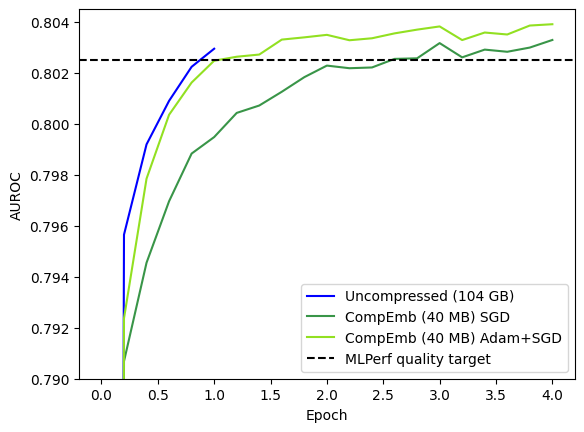

In [55]:
fig, ax = plt.subplots()
# robe_adamsgd_logs.plot(
#     x="epoch_frac", y="validation.val_auc", ax=ax, label="CompEmb Adam+SGD"
# )
unc_logs.plot(
    x="epoch_frac",
    y="validation.val_auc",
    ax=ax,
    label="Uncompressed (104 GB)",
    color="b",
)
# ht_sgd.plot(
#     x="epoch_frac",
#     y="validation.val_auc",
#     ax=ax,
#     label="Hashing Trick (41 MB)",
#     color="#FF9F33",
# )
robe_sgd_logs.plot(
    x="epoch_frac",
    y="validation.val_auc",
    ax=ax,
    label="CompEmb (40 MB) SGD",
    color="#399548",
)
robe_adamsgd_logs.plot(
    x="epoch_frac",
    y="validation.val_auc",
    ax=ax,
    label="CompEmb (40 MB) Adam+SGD",
    color="#92E021",
)
# dhe_sgd_logs.plot(
#     x="epoch_frac", y="validation.val_auc", ax=ax, label="DHE (44 MB)", color="#E021C6"
# )
plt.axhline(y=0.8025, color="k", linestyle="--", label="MLPerf quality target")
ax.set_ylim(0.79, 0.8045)
ax.set_xlabel("Epoch")
ax.set_ylabel("AUROC")
plt.legend()

plt.savefig("img/compemb_adam.png", dpi=300, bbox_inches="tight")